# Problem 3

## Problem(s) description

This problem was posted originally [in this Data Science job post](https://www.glassdoor.nl/Vacature/amsterdam-data-scientist-optiver-vacatures-SRCH_IL.0,9_IC3064478_KO10,24_KE25,32.htm). I reproduce it below for the sake of completness.

Calvin has to cross several signals when he walks from his home to school. Each of these signals operate independently. They alternate every 80 seconds between green light and red light. At each signal, there is a counter display that tells him how long it will be before the current signal changes. Calvin has a magic wand which lets him turn a signal from red to green instantaneously. However, this wand comes with limited battery life, so he can use it only for a specified number of times.
1. If the total number of signals is 2 and Calvin can use his magic wand only once, then what is the expected waiting time at the signals when Calvin optimally walks from his home to school?
2. What if the number of signals is 3 and Calvin can use his magic wand only once?
3. Can you write a code that takes as inputs the number of signals and the number of times Calvin can use his magic wand, and outputs the expected waiting time?

## Problem(s) solutions
Notation

* $N$ is the total number of signals.
* $W$ is the total number of times that the magic wand can be used. 
* $R_n$ denotes the binary event that the $n$-th signal is red when Calvin arrives, with $n=1,\dots,N$. 
* $X_n$ is the remaining time displayed at the counter of the $n$-th signal, with $n=1,\dots,N$.
* $T_n$ is the waiting time at the $n$-th signal, with $n=1,\dots,N$.


We assume that as long as the corresponding signal is green, Calvin can cross regardless of how much time is left for the green light.

### Case 1: $N=2$ signals and $W=1$ usage of the wand 
There are the following 2 situations, both occuring with probability 0.5:

1. If $R_1=0$, i.e. the first signal is green when Calvin arrives, then he neither has to wait nor use the wand, and he can spare its usage for the second signal in case that it is red. In this situation both $T_1 = 0$ and $T_2 = 0$.

2. If $R_1=1$, i.e. the first signal is red when Calvin arrives, then he should use the magic wand depending on $X_1$, the remaining time displayed at the first counter. We propose Strategy $(M)$, which consits of:

    a. If $X_1<=M$, then Calvin should wait until the first signal turns green and use the magic wand at the second signal if this one is red. In this situation, $T_1\sim$ unif(0,$M$) and $T_2 = 0$.
   
    b. If $X_1>M$, then Calvin should use the magic wand to turn the first signal into green and continue to the second signal, where he will have to wait in case that it is red since he cannot longer use the wand. In this situation, $T_1 = 0$ and $T_2\sim$ unif(0,80) or $T_2=0$, both  with probability 0.5.
    
##### Intuitively
If the second signal is red, then the waiting time can be modelled by a uniform distribution unif(0,80) with expected value 40. This situation only occurs with probabilhity 0.5, thus the expected waiting time is 20 seconds. So Calvin should use the wand at the first signal if the waiting time is larger than 20 and wait if the waiting time is less than 20, in other words $M=20$. For this reason, in the simulation we consider values of $M$ that include 20.

##### Mathematically
If $T = T_1 + T_2$ and $E_M$ denotes the expectation when using treshold $M$ for the strategy, then 
$$\begin{align}
E_M(T) & = E_M(T \,|\, R_1 = 0) \cdot  P(R_1 = 0) + E_M(T \,|\, R_1 = 1) \cdot  P(R_1 = 1) \\
       & = 0 \cdot  \frac{1}{2} + E_M(T \,|\, R_1 = 1) \cdot  \frac{1}{2}\end{align}$$
Thus we only have to compute the second term,
$$\begin{align}
E_M(T \,|\, R_1 = 1) & = E_M(T \,|\, R_1 = 1, X_1<=M) \cdot P(R_1 = 1, X_1<=M) + E_M(T \,|\, R_1 = 1, X_1>M) \cdot P(R_1 = 1, X_1>M) \\
                     & = \frac{M}{2}\cdot\frac{M}{80} + \left(\frac{80}{2}\cdot\frac12 + 0\cdot\frac12 \right)\cdot\frac{80-M}{80}\\
                   & = \frac{M^2}{160} -\frac{M}{4} + 20\end{align}$$
Substitutiong this quantity in the original equation, we get
$$E_M(T) = \left(\frac{M^2}{160} -\frac{M}{4} + 20\right) \cdot \frac{1}{2},$$

a parabola that opens upwards, so its critical point gives the minimum value. Taking the derivative of $E_M(T)$ with respect to $M$ and equating to 0 yields
$$\frac{d}{dM}E_M(T) = \left(\frac{2M}{160} -\frac{1}{4}\right) \cdot \frac{1}{2} = 0 \implies M = 20.$$

The minimum expected waiting time is obtained after evaluating $E_{M}(T)$ at $M=20$,
$$E_{20}(T) = \left(\frac{20^2}{160} -\frac{20}{4} + 20\right) \cdot \frac{1}{2} 
            = \left(\frac{400}{160} + 15\right) \cdot \frac{1}{2} = (17.5) \cdot \frac{1}{2}  = 8.75 \text{ seconds}.$$


## Functions for calculations

In [64]:
# Compute_wait_time: Computes recursively waiting time of signals (seconds).
#
# INPUT:
# N = (integer) total number of signals.
# W = (integer) total number of times that the magic wand can be used.
# period_length = (float) time period for duration of signal green and red ().
# prob_red = (float) probability that signal is red
# M = (float) treshold for Strategy(M), range [0, period_length]
#
# OUTPUT:
# (float) sum of waiting times of signals (seconds).
Compute_wait_time = function(
    N,
    W,
    period_length,
    prob_red,
    M){ 
    
  if(W >= N){ # There are as many wand usages as signals, then use the wand and do not wait at all.
      return(0)
      
  }else if(W == 0){ # There is zero wand usage, then wait for all the remaining signals that are RED.
      red_signals = runif(n = N, min = 0, max = period_length)
      wait_times = sample(x = c(1, 0), size = N, replace = TRUE, prob = c(prob_red, 1 - prob_red))
      
      # return sum of waiting times for red lights
      return(sum(red_signals * wait_times))
      
  }else{
      # Determine whether signal is red (=1) or green(=0),
      # with probabilities prob_red and prob_green = 1 - prob_red, respectively.
      is_red = sample(x = c(1, 0), size = 1, replace = TRUE, prob = c(prob_red, 1 - prob_red))
      
      if (is_red){ # Situation 2: Apply Strategy(M)
          # Generate time counter at traffic light
          X = runif(n = 1, min = 0, max = period_length)          
          if (X <= M) return(X + Compute_wait_time(N - 1, W, period_length, prob_red, M)) # Situation 2.a
          else return(Compute_wait_time(N - 1, W - 1, period_length, prob_red, M)) # Situation 2.b
          
      }else{ # Situation 1: If signal is green, then its waiting time is 0 so continue to next signals.
          return(Compute_wait_time(N - 1, W, period_length, prob_red, M))          
      }  
  } 
}
      
# Compute_mean_wait_time: Computes MEAN waiting time of signals(seconds).
#
# INPUT:
# num_experiemnts = (integer) total number of experiments used to compute mean.
# N = (integer) total number of signals.
# W = (integer) total number of times that the magic wand can be used.
# period_length = (float) time period for duration of signal green and red ().
# prob_red = (float) probability that signal is red
# M = (float) treshold for Strategy(M), range [0, period_length]
#
# OUTPUT:
# (float) mean of sum of waiting times of signals (seconds).
Compute_mean_wait_time = function(
    num_experiments,
    N,
    W,
    period_length,
    prob_red,
    M){ 
    
    waiting_times = sapply(1:num_experiments, function(i){
      Compute_wait_time(
          N, 
          W,
          period_length,
          prob_red,
          M)
    })    
    return(mean(waiting_times))
}

## Calculations

In [82]:
# Compute mean waiting time for different tresholds M
# for a high number of simulations
m_tresholds = seq(from = 0, to = 80, by = 0.5)
simulations = rep(0, length(m_tresholds))
num_simulations = 500

for (i in 1:num_simulations){
    waiting_times_m = sapply(m_tresholds, function(m){
      Compute_mean_wait_time(
        num_experiments = 100,
        N = 2,
        W = 1,
        period_length = 80,
        prob_red = 0.5,
        M = m)
    })    
    simulations = simulations + waiting_times_m
}

In [83]:
# parabola: Given a treshold m returns the expected waiting time according to calculations above.
parabola = function(m){
    return((m^2/160 - m/4 + 20)/2)
}

df = data.frame(tresholds = m_tresholds, 
                simulation = simulations / num_simulations, 
                exact = parabola(m_tresholds))

## Display results

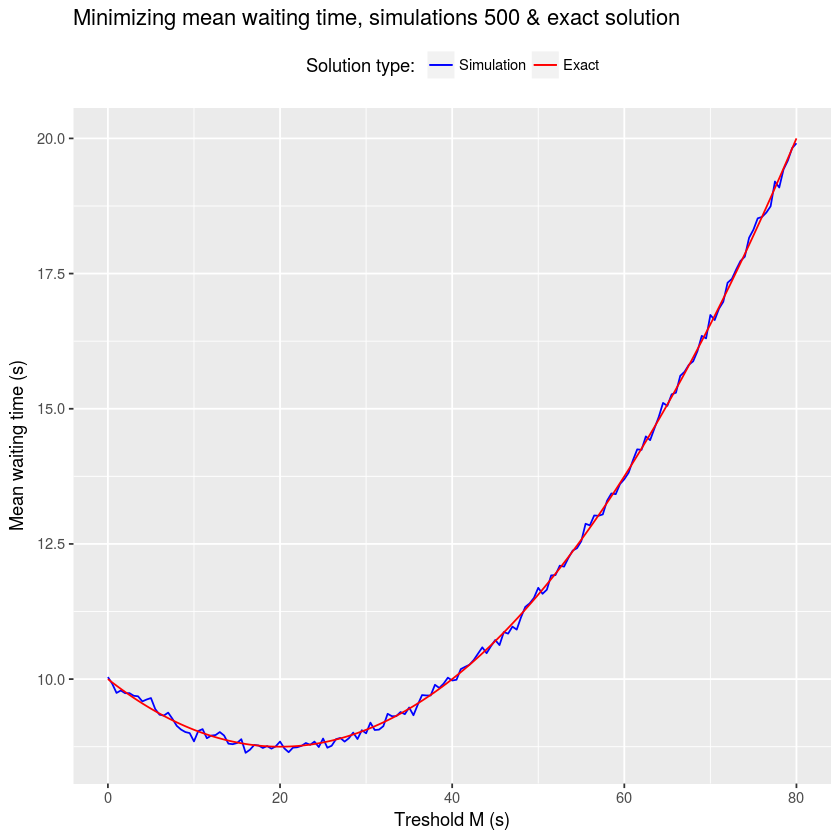

In [86]:
# Plots
library(ggplot2)

ggplot(data = df, aes(x = tresholds)) + 
    geom_line(aes(y = simulation, color = 'Simulation')) + 
    geom_line(aes(y = exact, color = 'Exact')) + 
    scale_color_manual('Solution type: ',
                       breaks = c('Simulation', 'Exact'),
                       values = c('Simulation'='blue', 'Exact'='red')) + 
    ylab('Mean waiting time (s)') +
    xlab('Treshold M (s)') + 
    ggtitle(paste('Minimizing mean waiting time, simulations', 
                  num_simulations,
                 '& exact solution')) +
    theme(legend.position = 'top')